2023-10-25

BBME 520

Assignment 6 Part A

Javid Jannat

In [99]:
import numpy as np 
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import sklearn
import nibabel as nib
from matplotlib import pyplot as plt
import scipy

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)

output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype= np.short) #gives 1 for females and 0 for males

data_n = output_variable.size
sets_n = 10

input_variables = [None]*sets_n

for i in range(sets_n):

    ROIS = (i+1)*100

    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=ROIS)
    print('%i regions found in this atlas' % (len(np.unique( nib.load(yeo.maps).get_fdata().ravel())) - 1))

    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables[i] = masker.fit_transform(brain_data.gray_matter_maps)

dims = np.zeros(sets_n)
for i in range(sets_n):
    dims[i] = input_variables[i].shape[1]

trainer = sklearn.linear_model.LogisticRegression(penalty='l2',C=1.0 , max_iter= 10000)

trainers = [None]*10

for i,hyperparam in enumerate(np.arange(0.1,1.1,0.1)):
    trainers[i] = sklearn.linear_model.LogisticRegression(penalty='l2', C= hyperparam , max_iter= 10000)

C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\datasets\struct.py:850: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


100 regions found in this atlas
200 regions found in this atlas
300 regions found in this atlas
400 regions found in this atlas
500 regions found in this atlas
600 regions found in this atlas
700 regions found in this atlas
800 regions found in this atlas
900 regions found in this atlas
1000 regions found in this atlas


In [100]:
#task 1

splitter = sklearn.model_selection.KFold(n_splits=5, shuffle=False)

accuracies = np.zeros(sets_n)

output = output_variable

for i, input in enumerate(input_variables):

    index_generator = splitter.split(input,output)

    for (train,test) in index_generator:

        model= trainer.fit(input[train],output[train])

        accuracies[i] += sum(model.predict(input[test]) == output_variable[test])/output_variable[test].size
        
accuracies *= 20


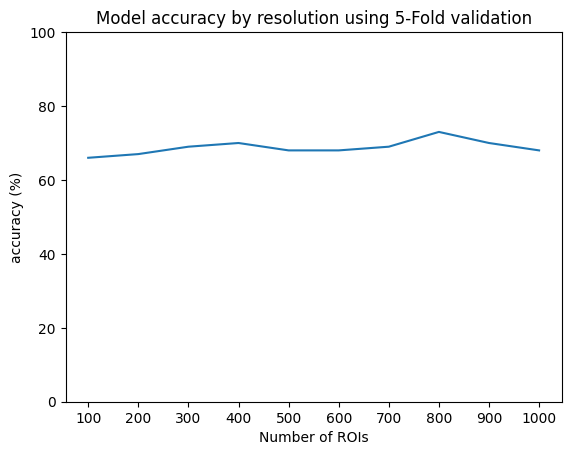

In [101]:
plt.title('Model accuracy by resolution using 5-Fold validation');
plt.plot(np.arange(sets_n), accuracies.transpose());
plt.ylim([0,100]);
plt.xticks(np.arange(sets_n),np.arange(100,1100,100));
plt.xlabel('Number of ROIs');
plt.ylabel('accuracy (%)');

In [102]:

#task 2

splitter = sklearn.model_selection.LeaveOneOut()

accuracies = np.zeros(sets_n)

output = output_variable

for i, input in enumerate(input_variables):

    index_generator = splitter.split(input,output)

    for (train,test) in index_generator:

        model= trainer.fit(input[train],output[train])

        accuracies[i] += sum(model.predict(input[test]) == output_variable[test])/output_variable[test].size


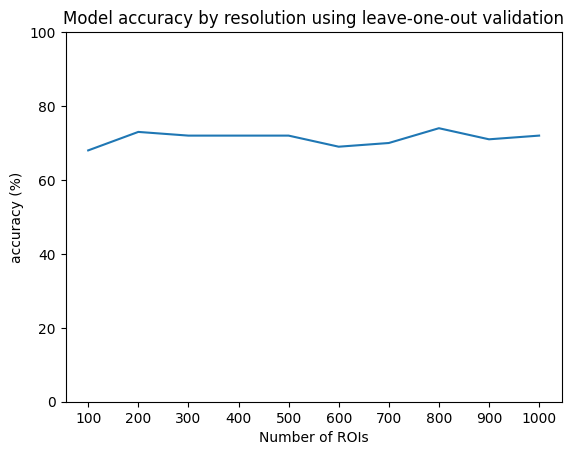

In [103]:
plt.title('Model accuracy by resolution using leave-one-out validation');
plt.plot(np.arange(sets_n), accuracies.transpose());
plt.ylim([0,100]);
plt.xticks(np.arange(sets_n),np.arange(100,1100,100));
plt.xlabel('Number of ROIs');
plt.ylabel('accuracy (%)');

In [104]:
#Task 3

splitter = sklearn.model_selection.ShuffleSplit(n_splits=50, train_size = round(data_n*0.8))

accuracies = np.zeros(sets_n)

output = output_variable

for i, input in enumerate(input_variables):

    index_generator = splitter.split(input,output)

    for (train,test) in index_generator:

        model= trainer.fit(input[train],output[train])

        accuracies[i] += sum(model.predict(input[test]) == output_variable[test])/output_variable[test].size

accuracies *= 2

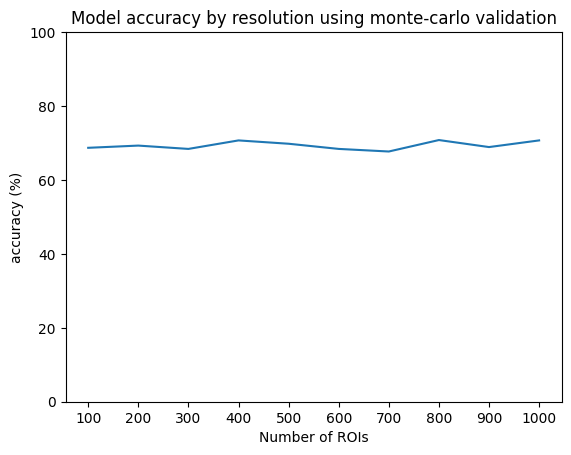

In [105]:
plt.title('Model accuracy by resolution using monte-carlo validation');
plt.plot(np.arange(sets_n), accuracies.transpose());
plt.ylim([0,100]);
plt.xticks(np.arange(sets_n),np.arange(100,1100,100));
plt.xlabel('Number of ROIs');
plt.ylabel('accuracy (%)');

In [106]:
#Task 4

splitter = sklearn.model_selection.StratifiedShuffleSplit(n_splits=50, train_size = round(data_n*0.8))

accuracies = np.zeros(sets_n)

output = output_variable

for i, input in enumerate(input_variables):

    index_generator = splitter.split(input,output)

    for (train,test) in index_generator:

        model= trainer.fit(input[train],output[train])

        accuracies[i] += sum(model.predict(input[test]) == output_variable[test])/output_variable[test].size

accuracies *= 2

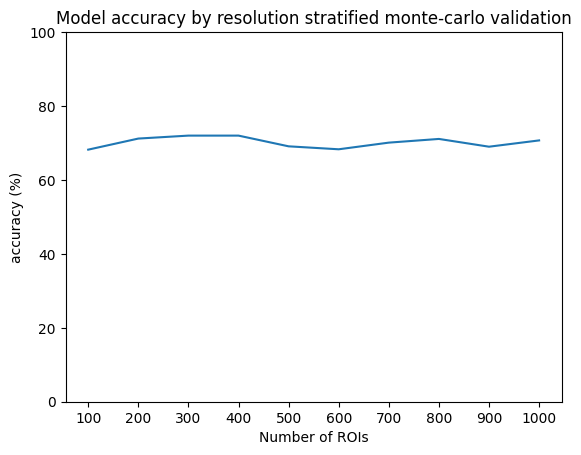

In [107]:
plt.title('Model accuracy by resolution stratified monte-carlo validation');
plt.plot(np.arange(sets_n), accuracies.transpose());
plt.ylim([0,100]);
plt.xticks(np.arange(sets_n),np.arange(100,1100,100));
plt.xlabel('Number of ROIs');
plt.ylabel('accuracy (%)');

In [108]:
#task 5

trainers = [None]*10

for i,hyperparam in enumerate(np.arange(0.1,1.1,0.1)):
    trainers[i] = sklearn.linear_model.LogisticRegression(penalty='l2', C= hyperparam , max_iter= 10000)

splitter_1 = sklearn.model_selection.KFold(n_splits=10, shuffle=False)
splitter_2 = sklearn.model_selection.KFold(n_splits=5, shuffle=False) # the number denotes the nestedness of the loop

searcher = sklearn.model_selection.GridSearchCV(trainer,{'C':np.arange(0.1,1.1,0.1)})

accuracies = np.zeros(sets_n)

output = output_variable

print('Progress:', end=' ')

for i, input in enumerate(input_variables):

    print(i, end=' ')

    index_generator_1 = splitter_1.split(input,output)

    for learn,test in index_generator_1:

        learn_input = input[learn]
        learn_output =  output[learn]

        index_generator_2 = splitter_1.split(learn_input,learn_output)
        
        accuracy_2 = 0
        best_trainer = 0

        for train, validate in index_generator_2:

            for t in trainers:

                model = t.fit(learn_input[train],learn_output[train])               # My computer was too slow to use GridSearchCV
                model_score = model.score(learn_input[validate],learn_output[validate])

                if (model_score > accuracy_2):

                    accuracy_2 = model_score
                    best_trainer = t


        model= best_trainer.fit(input[learn],output[learn])

        accuracies[i] += model.score(input[test], output[test])
        
accuracies*=10

Progress: 0 1 2 3 4 5 6 7 8 9 

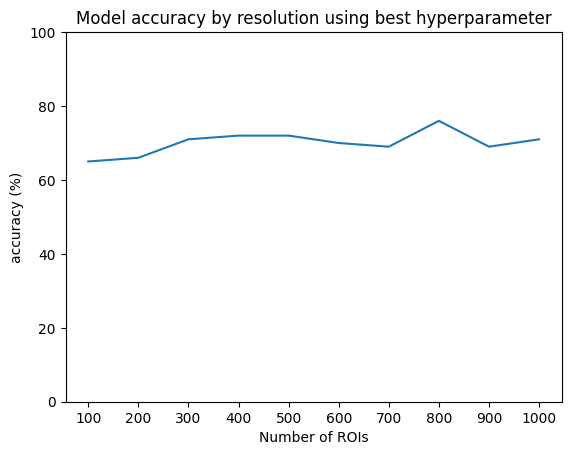

In [109]:
plt.title('Model accuracy by resolution using best hyperparameter');
plt.plot(np.arange(sets_n), accuracies.transpose());
plt.ylim([0,100]);
plt.xticks(np.arange(sets_n),np.arange(100,1100,100));
plt.xlabel('Number of ROIs');
plt.ylabel('accuracy (%)');